<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Experimento 2 AutoGluon</h4>
</center>

In [1]:
# !pip install autogluon
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [2]:
df = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product_fill_extreme_values_095.csv", header = None)
df.columns = ["timestamp", "item_id", "target"]
df.head(5)

,timestamp,item_id,target
0,2017-01-01,20001,934.77222
1,2017-02-01,20001,798.01620
2,2017-03-01,20001,1303.35771
3,2017-04-01,20001,1069.96130
4,2017-05-01,20001,1502.20132


In [3]:
data = TimeSeriesDataFrame(df)
data

target
item_id timestamp              
20001   2017-01-01   934.772220
        2017-02-01   798.016200
        2017-03-01  1303.357710
        2017-04-01  1069.961300
        2017-05-01  1502.201320
...                         ...
21087   2019-12-01     1.022050
21214   2019-09-01     0.342500
        2019-10-01     0.217350
        2019-11-01     0.765477
        2019-12-01     0.244280

[22349 rows x 1 columns]

In [4]:
predictor = TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data, num_val_windows = 3)
predictions = predictor.predict(data)

Frequency 'M' stored as 'ME'
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels\ag-20240706_144353'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.77 GB / 7.88 GB (9.8%)
Disk Space Avail:   10.32 GB / 110.21 GB (9.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'ME',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'ME'.
Provided train_data has 22375 rows (NaN fraction=0.1%), 780 time se

In [5]:
predictions_v1 = predictions.copy()
predictions_v1 = predictions_v1.reset_index()
predictions_v1 = predictions_v1[["item_id", "timestamp", "mean"]]
predictions_v1 = predictions_v1[predictions_v1.timestamp == "2020-02-29"]
predictions_v1 = predictions_v1.drop(columns = {"timestamp"})
predictions_v1 = predictions_v1.rename(columns = {"item_id":"product_id", "mean":"tn"})
predictions_v1.head(5)

,product_id,tn
1,20001,1348.282951
3,20002,1060.431026
5,20003,771.820966
7,20004,549.222261
9,20005,556.563102


In [6]:
predictions_v1.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Outputs/prediccion_autogluon_fill_upper_outliers.csv", sep = ",", index = False)

Post procesamientos

In [5]:
ventas = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product.csv", header = None)
ventas.columns = ["periodo", "product_id", "tn"]
ventas.head(5)

,periodo,product_id,tn
0,2017-01-01,20001,934.77222
1,2017-01-01,20002,550.15707
2,2017-01-01,20003,1063.45835
3,2017-01-01,20004,555.91614
4,2017-01-01,20005,494.27011


In [6]:
inferencias = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Outputs/prediccion_autogluon_fill_upper_outliers.csv", sep = ",")
inferencias.columns = ["product_id", "tn"]
inferencias["periodo"] = "2020-02-01"
inferencias = inferencias[["periodo", "product_id", "tn"]]
inferencias.head(5)

,periodo,product_id,tn
0,2020-02-01,20001,1348.282951
1,2020-02-01,20002,1060.431026
2,2020-02-01,20003,771.820966
3,2020-02-01,20004,549.222261
4,2020-02-01,20005,556.563102


In [21]:
historico_forecast = pd.concat([ventas, inferencias])
historico_forecast['periodo'] = pd.to_datetime(historico_forecast['periodo'])
historico_forecast.head(1)

,periodo,product_id,tn
0,2017-01-01,20001,934.77222


In [25]:
def plot_total_tn_per_month(df):
    # Agrupar por mes y sumar las toneladas
    df['month'] = df['periodo'].dt.to_period('M')
    monthly_total_tn = df.groupby('month')['tn'].sum()
    
    # Convertir el índice a tipo datetime para la graficación
    monthly_total_tn.index = monthly_total_tn.index.to_timestamp()

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_total_tn.index, monthly_total_tn, marker='o', linestyle='-')
    plt.title('Total de Toneladas por Mes')
    plt.xlabel('Mes')
    plt.ylabel('Toneladas')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

def plot_tn_per_product_per_month(df):
    # Agrupar por mes y product_id, y sumar las toneladas
    df['month'] = df['periodo'].dt.to_period('M')
    monthly_product_tn = df.groupby(['month', 'product_id'])['tn'].sum().unstack(fill_value=0)
    
    # Convertir el índice a tipo datetime para la graficación
    monthly_product_tn.index = monthly_product_tn.index.to_timestamp()

    # Graficar
    plt.figure(figsize=(10, 6))
    for product_id in monthly_product_tn.columns:
        plt.plot(monthly_product_tn.index, monthly_product_tn[product_id], marker='o', linestyle='-', label=product_id)
    
    plt.title('Toneladas por Mes por Producto')
    plt.xlabel('Mes')
    plt.ylabel('Toneladas')
    plt.legend(title='Product ID')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

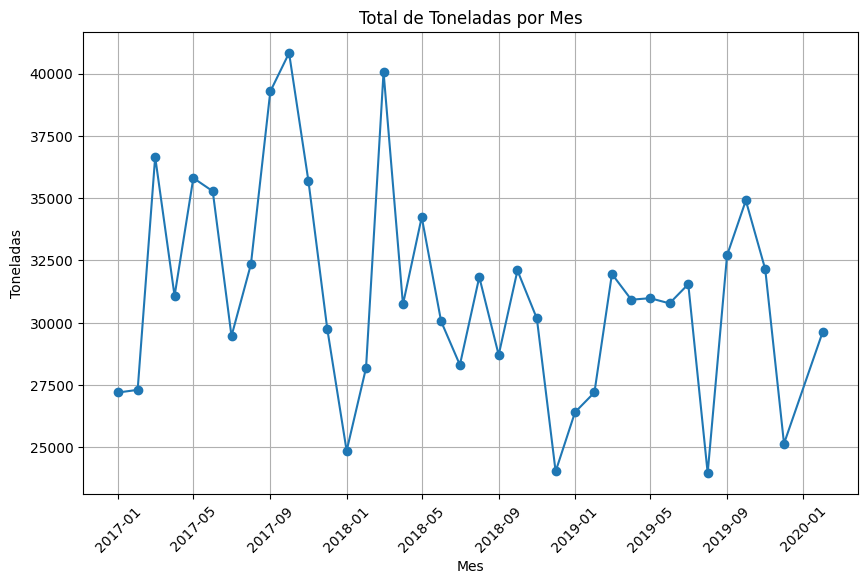

In [24]:
plot_total_tn_per_month(historico_forecast)

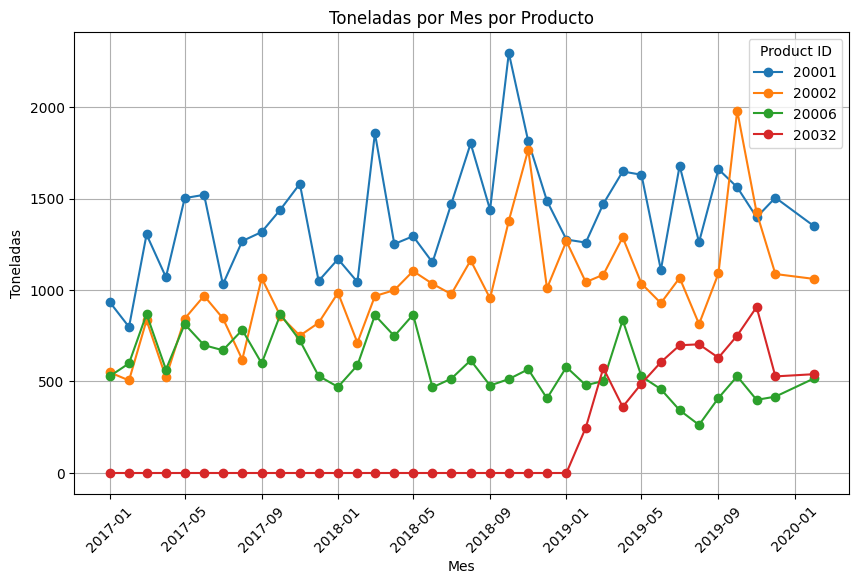

In [33]:
plot_tn_per_product_per_month(historico_forecast[historico_forecast.product_id.isin([20001, 20002, 20006, 20032])])

Vemos que el volumen de febrero está sobre-estimado a nivel general.
Sin embargo, algunos de los productos más improtante si captan tendencia decreciente del ultimo tiempo.
Entonces: para productos que predicen febrero 20 > diciembre 19, replicamos valor de diciembre 19

In [55]:
historico_forecast_corregido = historico_forecast.drop(columns = "month")

# Definir las fechas clave
fecha_2019_12_01 = pd.Timestamp('2019-12-01')
fecha_2020_02_01 = pd.Timestamp('2020-02-01')

# Obtener una lista única de product_id
product_ids = historico_forecast_corregido['product_id'].unique()

# Iterar sobre cada product_id
for product_id in product_ids:
    # Obtener los valores de tn para las fechas clave para el product_id actual
    tn_2019_12_01 = historico_forecast_corregido.loc[
        (historico_forecast_corregido['periodo'] == fecha_2019_12_01) &
        (historico_forecast_corregido['product_id'] == product_id), 'tn'
    ].values

    tn_2020_02_01 = historico_forecast_corregido.loc[
        (historico_forecast_corregido['periodo'] == fecha_2020_02_01) &
        (historico_forecast_corregido['product_id'] == product_id), 'tn'
    ].values

    # Verificar si ambos valores existen
    if len(tn_2019_12_01) > 0 and len(tn_2020_02_01) > 0:
        tn_2019_12_01 = tn_2019_12_01[0]
        tn_2020_02_01 = tn_2020_02_01[0]

        # Verificar la condición y actualizar el valor de tn para 2020-02-01 si es necesario
        if tn_2020_02_01 > tn_2019_12_01:
            historico_forecast_corregido.loc[
                (historico_forecast_corregido['periodo'] == fecha_2020_02_01) &
                (historico_forecast_corregido['product_id'] == product_id), 'tn'
            ] = tn_2019_12_01

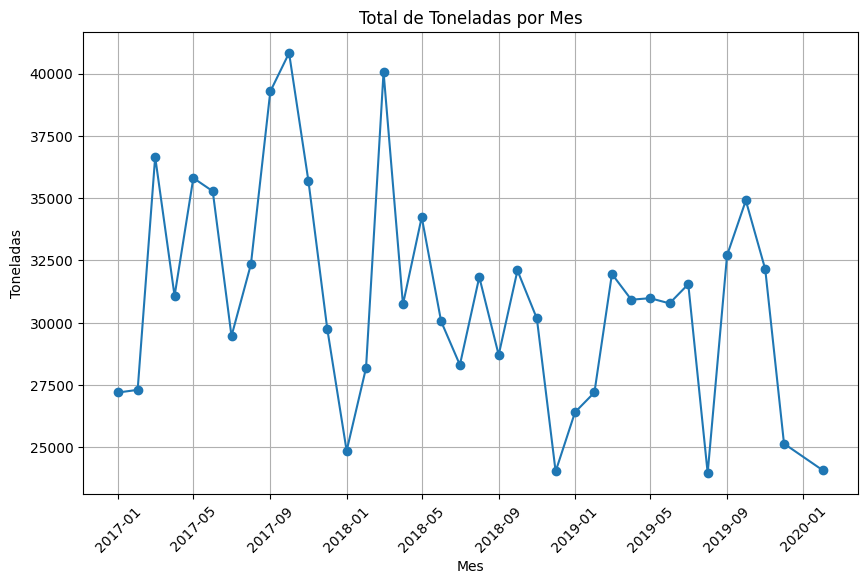

In [56]:
plot_total_tn_per_month(historico_forecast_corregido)

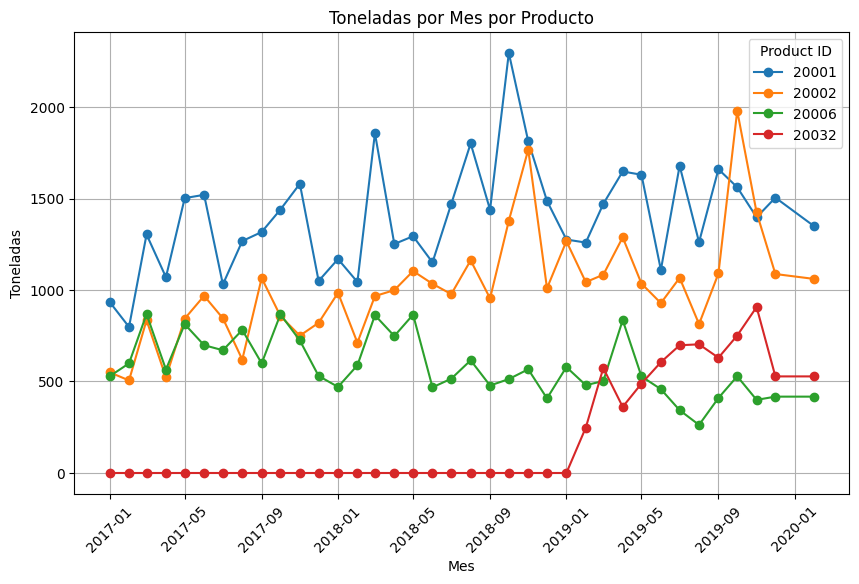

In [57]:
plot_tn_per_product_per_month(historico_forecast_corregido[historico_forecast_corregido.product_id.isin([20001, 20002, 20006, 20032])])

In [58]:
historico_forecast_corregido = historico_forecast_corregido

In [59]:
predictions_ajustadas = historico_forecast_corregido.drop(columns = "month")
predictions_ajustadas = predictions_ajustadas[["product_id", "periodo", "tn"]]
predictions_ajustadas = predictions_ajustadas[predictions_ajustadas.periodo == "2020-02-01"]
predictions_ajustadas = predictions_ajustadas.drop(columns = {"periodo"})
predictions_ajustadas.head(5)

,product_id,tn
0,20001,1348.282951
1,20002,1060.431026
2,20003,771.820966
3,20004,549.222261
4,20005,556.563102


In [60]:
predictions_ajustadas.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Outputs/prediccion_autogluon_fill_upper_outliers_ajusted.csv", sep = ",", index = False)